In [1]:
import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from tqdm.auto import tqdm

from datasets import get_dataset
from first_order import Ig, Nesterov
from loss_functions import LogisticRegression
from stochastic_first_order import Sgd, Shuffling
from utils import get_trace, relative_round
%load_ext autoreload
%autoreload 2

import matplotlib
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

## Get data and set all parameters

In [3]:
dataset = 'w8a'
# dataset = 'gisette'
A, b = get_dataset(dataset)

loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness()
l2 = L / np.sqrt(n)
loss.l2 = l2
x0 = csc_matrix((dim, 1))
n_epoch = 600
batch_size = 512
n_seeds = 2 # was set to 20 in the paper
stoch_it = 250 * n // batch_size
trace_len = 300
trace_path = f'results/log_reg_{dataset}_l2_{relative_round(l2)}/'

## Run the methods

In [4]:
nest_str_trace = get_trace(f'{trace_path}nest_str', loss)
if not nest_str_trace:
    nest_str = Nesterov(loss=loss, it_max=n_epoch, mu=l2, strongly_convex=True)
    nest_str_trace = nest_str.run(x0=x0)
    nest_str_trace.compute_loss_of_iterates()
    nest_str_trace.save('nest_str', trace_path)
    nest_str_trace.plot_losses()
    plt.yscale('log')
f_opt = np.min(nest_str_trace.loss_vals)
x_opt = nest_str_trace.xs[-1]

In [5]:
rr_trace = get_trace(f'{trace_path}rr', loss)
if not rr_trace:
    rr_lr0 = 1 / l2
    rr_decay_coef = l2 / 3
    rr_lr_max = 1 / loss.batch_smoothness(batch_size)
    rr = Shuffling(loss=loss, lr0=rr_lr0, lr_max=rr_lr_max, lr_decay_coef=rr_decay_coef, 
                   it_max=stoch_it, n_seeds=n_seeds, batch_size=batch_size, trace_len=trace_len)
    rr_trace = rr.run(x0=x0)
    rr_trace.convert_its_to_epochs(batch_size=batch_size)
    rr_trace.compute_loss_of_iterates()
    rr_trace.save('rr', trace_path)

In [6]:
c_rr_trace_list = []
clip_level_list = np.logspace(-3, 2, 6)
for clip_level in tqdm(clip_level_list):
    c_rr_trace = get_trace(f'{trace_path}c_{clip_level}_rr', loss)
    if not c_rr_trace:
        c_rr_lr0 = 1 / l2
        c_rr_decay_coef = l2 / 3
        c_rr_lr_max = 1 / loss.batch_smoothness(batch_size)
        c_rr = Shuffling(
            loss=loss, 
            lr0=c_rr_lr0, 
            lr_max=c_rr_lr_max, 
            lr_decay_coef=c_rr_decay_coef, 
            it_max=stoch_it, 
            n_seeds=n_seeds, 
            batch_size=batch_size, 
            trace_len=trace_len,
            clip_level=clip_level
        )
        c_rr_trace = c_rr.run(x0=x0)
        c_rr_trace.convert_its_to_epochs(batch_size=batch_size)
        c_rr_trace.compute_loss_of_iterates()
        c_rr_trace.save(f'c_{clip_level}_rr', trace_path)
    c_rr_trace_list.append(c_rr_trace)

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
so_trace = get_trace(f'{trace_path}so', loss)
if not so_trace:
    so_lr0 = 1 / l2
    so_decay_coef = l2 / 3
    so_lr_max = 1 / loss.batch_smoothness(batch_size)
    so = Shuffling(loss=loss, lr0=so_lr0, lr_max=so_lr_max, lr_decay_coef=so_decay_coef, 
                   it_max=stoch_it, n_seeds=n_seeds, batch_size=batch_size, steps_per_permutation=np.inf, trace_len=trace_len)
    so_trace = so.run(x0=x0)
    so_trace.convert_its_to_epochs(batch_size=batch_size)
    so_trace.compute_loss_of_iterates()
    so_trace.save('so', trace_path)

In [8]:
sgd_trace = get_trace(f'{trace_path}sgd_no_miss', loss)
sgd_perm = np.random.permutation(n)
loss_sgd = LogisticRegression(A[sgd_perm], b[sgd_perm], l1=0, l2=l2)
if not sgd_trace:
    sgd_lr0 = 1 / l2
    sgd_decay_coef = l2 / 2
    sgd_lr_max = 1 / loss.batch_smoothness(batch_size)
    sgd = Sgd(loss=loss_sgd, lr_max=sgd_lr_max, lr0=sgd_lr0, lr_decay_coef=sgd_decay_coef, 
              it_max=stoch_it, n_seeds=1, batch_size=batch_size, avoid_cache_miss=True, trace_len=trace_len)
    sgd_trace = sgd.run(x0=x0)
    sgd_trace.convert_its_to_epochs(batch_size=batch_size)
    sgd_trace.compute_loss_of_iterates()
    sgd_trace.save('sgd_no_miss', trace_path)

In [9]:
ig_trace = get_trace(f'{trace_path}ig', loss)
if not ig_trace:
    ig_lr0 = 1 / l2
    ig_decay_coef = l2 / 3
    ig_lr_max = 1 / loss.batch_smoothness(batch_size)
    ig = Ig(loss=loss, lr0=ig_lr0, lr_max=ig_lr_max, lr_decay_coef=ig_decay_coef, it_max=stoch_it, 
            batch_size=batch_size, trace_len=trace_len)
    ig_trace = ig.run(x0=x0)
    ig_trace.convert_its_to_epochs(batch_size=batch_size)
    ig_trace.compute_loss_of_iterates()
    ig_trace.save('ig', trace_path)

In [10]:
traces = [sgd_trace, ig_trace, so_trace, rr_trace, *c_rr_trace_list]

# Performance plots

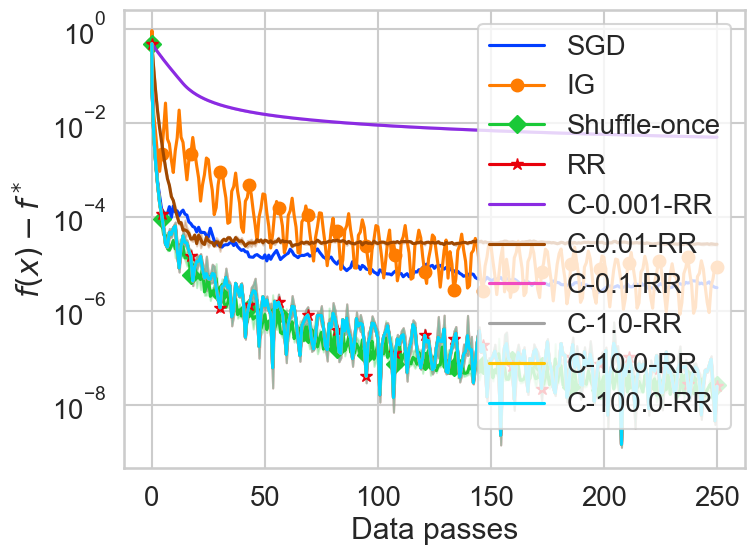

In [20]:
traces = [sgd_trace, ig_trace, so_trace, rr_trace, *c_rr_trace_list]
labels = ['SGD', 'IG', 'Shuffle-once', 'RR'] + [f'C-{c_level}-RR' for c_level in clip_level_list]
markers = [',', 'o', 'D', '*'] + [','] * len(clip_level_list)
for trace, label, marker in zip(traces, labels, markers):
    trace.plot_losses(f_opt=f_opt, label=label, marker=marker)
plt.yscale('log')
plt.legend()
plt.xlabel('Data passes')
plt.tight_layout()
# plt.savefig(f'./plots/{dataset}_func.pdf', dpi=300)

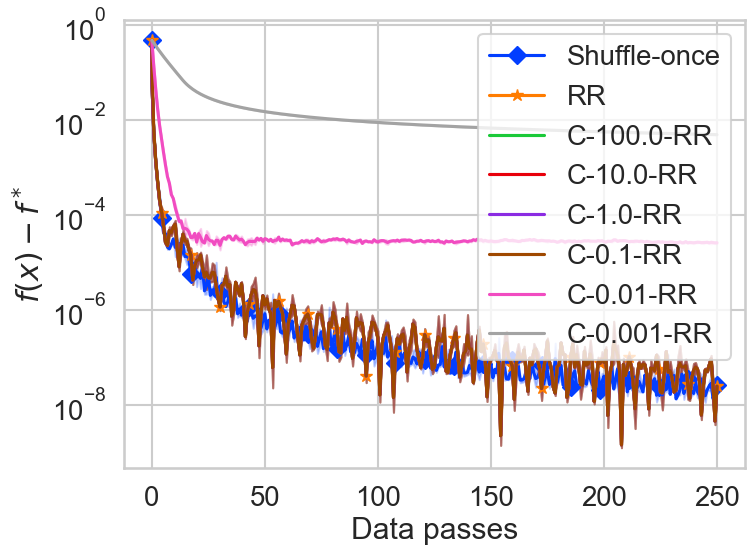

In [21]:
traces = [so_trace, rr_trace] + list(reversed(c_rr_trace_list))
labels = ['Shuffle-once', 'RR'] + [f'C-{c_level}-RR' for c_level in reversed(clip_level_list)]
markers = ['D', '*'] + [','] * len(clip_level_list)
for trace, label, marker in zip(traces, labels, markers):
    trace.plot_losses(f_opt=f_opt, label=label, marker=marker)
plt.yscale('log')
plt.legend()
plt.xlabel('Data passes')
plt.tight_layout()
# plt.savefig(f'./plots/{dataset}_func.pdf', dpi=300)

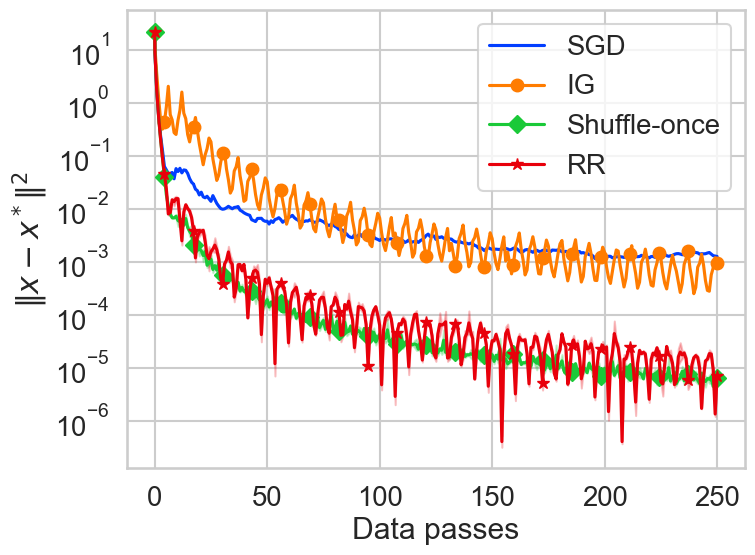

In [9]:
for trace, label, marker in zip(traces, labels, markers):
    trace.plot_distances(x_opt=x_opt, label=label, marker=marker)
plt.yscale('log')
plt.legend()
plt.xlabel('Data passes')
plt.tight_layout()
plt.savefig(f'./plots/{dataset}_dist.pdf', dpi=300)

## Effect of permutaiton

In [11]:
import time
so_trace = get_trace(f'{trace_path}so_many', loss)
if not so_trace:
    so_lr0 = 0.05 / loss.batch_smoothness(batch_size)
    so_decay_coef = l2 / 3
    so_lr_max = 0.05 / loss.batch_smoothness(batch_size)
    so = Shuffling(loss=loss, lr0=so_lr0, lr_max=so_lr_max, lr_decay_coef=so_decay_coef,
                   it_max=4 * n // batch_size, n_seeds=500, batch_size=batch_size, steps_per_permutation=np.inf, trace_len=100)
    so_trace = so.run(x0=nest_str_trace.xs[40])
    so_trace.convert_its_to_epochs(batch_size=batch_size)
    so_trace.compute_loss_of_iterates()
    so_trace.save('so_many', trace_path)

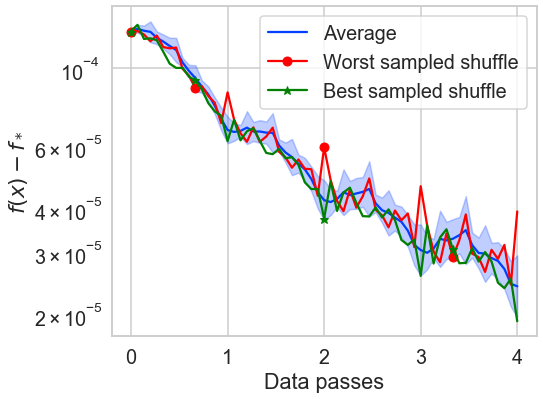

In [64]:
worst_val = 0
best_val = np.inf
for loss_vals in so_trace.loss_vals_all.values():
    last_ave = np.min(loss_vals)
    if last_ave < best_val:
        best_val = last_ave
        best_vals = loss_vals
    elif last_ave > worst_val:
        worst_val = last_ave
        worst_vals = loss_vals
so_trace.plot_losses(f_opt=f_opt, label='Average')
plt.plot(so_trace.its, worst_vals - f_opt, color='red', label='Worst sampled shuffle', marker='o', markevery=20)
plt.plot(so_trace.its, best_vals - f_opt, color='green', label='Best sampled shuffle', marker='*', markevery=20)
plt.yscale('log')
plt.xlabel('Data passes')
plt.ylabel(r'$f(x)-f_*$')
plt.legend()
plt.tight_layout()
plt.savefig(f'./plots/{dataset}_so_many.pdf', dpi=300)

## Measure variance

In [13]:
from utils import variance_at_opt

In [156]:
import time
batches = [1, 4, 8] + list(np.unique(np.logspace(1, np.log10(loss.n // 30), num=50, dtype=int)))
n_perms = 10
vars_sgd = []
vars_rr = []
vars_rr_upper = []
vars_rr_lower = []
for b in batches:
    var_sgd, var_rr, var_rr_uper, var_rr_lower = variance_at_opt(x_opt, loss, batch_size=b, n_perms=n_perms)
    vars_sgd.append(var_sgd)
    vars_rr.append(var_rr)
    vars_rr_upper.append(var_rr_uper)
    vars_rr_lower.append(var_rr_lower)

In [204]:
with open(f'{trace_path}batch_variance_sgd.npy', 'wb') as f:
    np.save(f, vars_sgd)
with open(f'{trace_path}batch_variance_rr.npy', 'wb') as f:
    np.save(f, vars_rr)
with open(f'{trace_path}batch_variance_rr_upper.npy', 'wb') as f:
    np.save(f, vars_rr_upper)
with open(f'{trace_path}batch_variance_rr_lower.npy', 'wb') as f:
    np.save(f, vars_rr_lower)

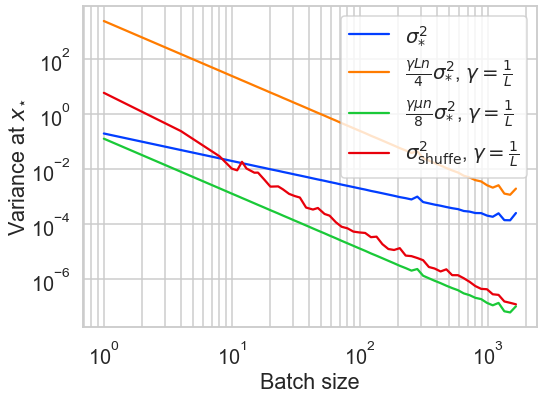

In [203]:
plt.plot(batches, vars_sgd, label=r'$\sigma_{*}^2$')
plt.plot(batches, vars_rr_upper, label=r'$\frac{\gamma L n}{4}\sigma_{*}^2$, $\gamma=\frac{1}{L}$')
plt.plot(batches, vars_rr_lower, label=r'$\frac{\gamma \mu n}{8}\sigma_{*}^2$, $\gamma=\frac{1}{L}$')
plt.plot(batches, vars_rr, label=r'$\sigma_{\mathrm{shuffe}}^2$, $\gamma=\frac{1}{L}$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Variance at $x_{\star}$')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.tight_layout()
plt.savefig(f'./plots/{dataset}_variance_batchsize.pdf', dpi=300)

In [227]:
import time
lrs_inv = np.linspace(1, 10**4, 50)
batch = 64
n_perms = 10
vars_sgd = []
vars_rr = []
vars_rr_upper = []
vars_rr_lower = []
for lr_inv in lrs_inv:
    lr = 1 / lr_inv / loss.max_smoothness()
    t_s = time.time()
    var_sgd, var_rr, var_rr_uper, var_rr_lower = variance_at_opt(x_opt, loss, batch_size=batch, n_perms=n_perms, lr=lr)
    vars_sgd.append(var_sgd)
    vars_rr.append(var_rr)
    vars_rr_upper.append(var_rr_uper)
    vars_rr_lower.append(var_rr_lower)
    t_dif = time.time() - t_s
    print(lr * loss.max_smoothness(), t_dif, np.log(var_sgd), np.log(var_rr), end='\r')

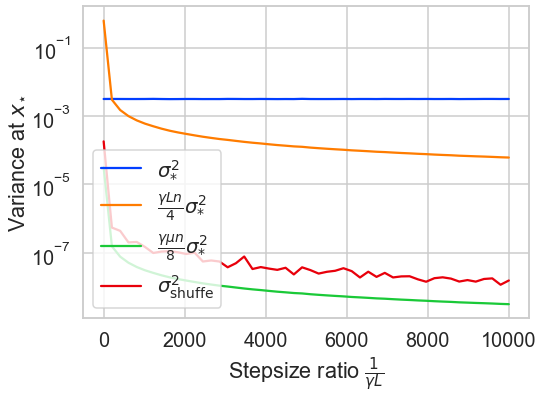

In [237]:
plt.plot(lrs_inv, vars_sgd, label=r'$\sigma_{*}^2$')
plt.plot(lrs_inv, vars_rr_upper, label=r'$\frac{\gamma L n}{4}\sigma_{*}^2$')
plt.plot(lrs_inv, vars_rr_lower, label=r'$\frac{\gamma \mu n}{8}\sigma_{*}^2$')
plt.plot(lrs_inv, vars_rr, label=r'$\sigma_{\mathrm{shuffe}}^2$')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'Stepsize ratio $\frac{1}{\gamma L}$')
plt.ylabel('Variance at $x_{\star}$')
# plt.grid(True, which="both", ls="-")
plt.legend()
plt.tight_layout()
plt.savefig(f'./plots/{dataset}_variance_stepsize.pdf', dpi=300)

In [216]:
with open(f'{trace_path}lr_variance_sgd.npy', 'wb') as f:
    np.save(f, vars_sgd)
with open(f'{trace_path}lr_variance_rr.npy', 'wb') as f:
    np.save(f, vars_rr)
with open(f'{trace_path}lr_variance_rr_upper.npy', 'wb') as f:
    np.save(f, vars_rr_upper)
with open(f'{trace_path}lr_variance_rr_lower.npy', 'wb') as f:
    np.save(f, vars_rr_lower)

# Histogram

In [9]:
import time
batch = 64
n_perms = 1
vars_so = []
t_s = time.time()
for _ in range(1000):
    lr = 1 / loss.max_smoothness()
    __, var_so, __, __ = variance_at_opt(x_opt, loss, batch_size=batch, n_perms=n_perms, lr=lr)
    vars_so.append(var_so)
t_dif = time.time() - t_s
print(t_dif)

In [444]:
__, var_ig, __, __ = variance_at_opt(x_opt, loss, batch_size=batch, perms=[np.arange(0, n)], lr=lr)

In [420]:
with open(f'{trace_path}variance_so_hist.npy', 'wb') as f:
    np.save(f, vars_so)

In [553]:
colors = sns.color_palette('coolwarm', len(patches))

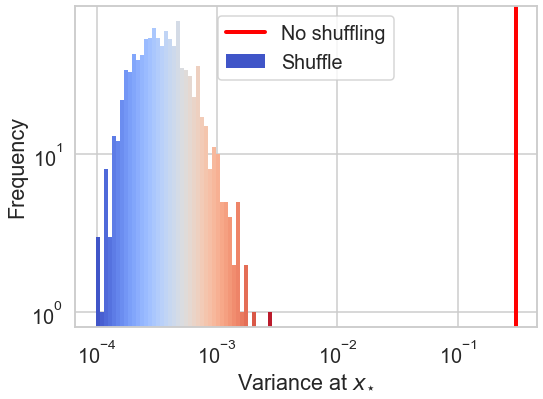

In [554]:
bins = np.logspace(np.log10(np.min(vars_so)), np.log10(np.max(vars_so)), 45)
freq, bins, patches = plt.hist(vars_so, bins=bins, edgecolor='#e0e0e0', linewidth=0., alpha=1, log=True, label='Shuffle')

freq = freq.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])
plt.xlabel(r'Variance at $x_{\star}$')
plt.ylabel('Frequency')
plt.axvline(x=var_ig, color='red', label='No shuffling', linewidth=4)
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.savefig(f'./plots/{dataset}_variance_histogram.pdf', dpi=300)